In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter

1. Load the dataset 

In [2]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


In [3]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df = test_df.drop(columns=['data_source'])
test_df['length'] = test_df['protein_sequence'].str.len()

2. Translate Amino-acids to numbers and create a One-Channel array for each sequence

In [4]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()

In [5]:
# fix max_length to be 500
max_length = 500

#drop rows that exceeds this value

train_df = train_df[train_df['length'] < max_length]



In [6]:
len(train_df)

20510

In [7]:

def encode_seq(sequence):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] # aa letters
    char_to_int = dict((c, i) for i, c in enumerate(alphabet)) 
    integer_encoded = [char_to_int[char] for char in sequence] #each character becomes int
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))] #0 for all letters
        letter[value] = 1 #modify the column corresponding to the letter to 1
        onehot_encoded.append(letter) #put in the array (1 letter = 1 array of 20 columns)
    
    ar =   np.transpose(np.array(onehot_encoded))
    zeros = np.zeros([len(alphabet),max_length - len(integer_encoded)] )
    onehot_encoded = np.concatenate((ar, zeros), axis = 1) #zero padding


    return onehot_encoded #we have all arrays, corresponding to the whole sequence


# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x))
test_df['encoded_sequence'] = test_df['protein_sequence'].apply(lambda x: encode_seq(x))

In [8]:
train_df['encoded_sequence'].shape

(20510,)

In [9]:
#final dataframe 
train_df.head()

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [10]:
df = train_df.copy()

In [11]:
df = df.reset_index(drop=True)

In [12]:
test_df = test_df.reset_index(drop=True)

Split to train and validation sets

In [13]:
#splot padded_train_df into train and validation sets (will be put in a function later)
train_df = df.sample(frac=0.8,random_state=24)
val_df = df.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [14]:
print(len(train_df),len(val_df))

16408 4102


si met la transformation dans le dataframe : le kernel dies
Si met avant, dans le panda, les dimensions sont pas les bonnes (peut être transposer ??)

In [15]:
df

,protein_sequence,pH,tm,length,encoded_sequence
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
4,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
20505,YWFPAEEMRTRNNVNNCFKKPAFANLLRFPQLYPFLCRADFIKVAA...,7.0,48.6,300,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
20506,YYAYVVELCVSTISRTGEKGKTVVYLVAFHLFFVMFVWSYWMTIFT...,7.0,49.4,350,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
20507,YYLWHKAASTVASIHESIDKSKKRDKEVSINKKDPFSVLIMGVDER...,7.0,42.1,274,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,..."
20508,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,37.2,469,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Create 1d conv net

1. get DataLoader from train_dl

In [16]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df,train=True):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df[['pH','length']].values

        # y : the target (tm)
        if train == True : 
            y=df['tm'].values
        else : 
            y = np.zeros(len(sequence))
        self.y=torch.tensor(y,dtype=torch.float32)
        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
       
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [17]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100


In [18]:
# create pytorch dataframes
train_d = EnzymesDataset(df)
val_d = EnzymesDataset(test_df,train=False)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_831317/545355855.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.x_sequence=torch.tensor(sequence)


In [19]:
def predict(model,test_loader):
    model = model.eval()
    df_predicted = pd.DataFrame()
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            df_predicted = df_predicted.append(pd.DataFrame({'tm':output.squeeze().cpu().detach().numpy()}))
    return df_predicted

In [20]:
import optuna
import torch.optim as optim
import torch.nn.functional as F

In [32]:
class Conv1D_OneChannel(nn.Module):
    
    
    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
        """Parameters:
            - trial (optuna.trial._trial.Trial): Optuna trial
            - num_conv_layers (int):             Number of convolutional layers
            - num_filters (list):                Number of filters of conv layers
            - num_neurons (int):                 Number of neurons of FC layers
            - drop_conv2 (float):                Dropout ratio for conv layer 2
            - drop_fc1 (float):                  Dropout ratio for FC1
        """
        super(Conv1D_OneChannel, self).__init__()                                                     # Initialize parent class
        in_size = 20                                                                    # Input image size (28 pixels)
        kernel_size = 3                                                                 # Convolution filter size

        # Define the convolutional layers
        self.convs = nn.ModuleList([nn.Conv1d(in_size, num_filters[0], kernel_size=(3, 3))])  # List with the Conv layers
        out_size = in_size - kernel_size + 1                                            # Size of the output kernel
        out_size = int(out_size / 2)                                                    # Size after pooling
        for i in range(1, num_conv_layers):
            self.convs.append(nn.Conv1d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=(3, 3)))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2))
            self.convs.append(nn.MaxPool1d(kernel_size=3, stride=2))
            
            out_size = out_size - kernel_size + 1                                       # Size of the output kernel
            out_size = int(out_size/2)                                                  # Size after pooling
        self.convs.append(nn.Dropout(p=drop_conv2))
        self.convs.append(nn.Flatten())
        
        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Size of flattened features
           
        
        
        """self.conv2_drop = nn.Dropout(p=drop_conv2)                                    # Dropout for conv2
        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Size of flattened features
        self.fc1 = nn.Linear(self.out_feature, num_neurons)                             # Fully Connected layer 1
        self.fc2 = nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
        self.p1 = drop_fc1  """
        
        
        # Initialize weights with the He initialization
        """for i in range(1, num_conv_layers):
            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
            if self.convs[i].bias is not None:
                nn.init.constant_(self.convs[i].bias, 0)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')"""
        
        

        self.numerical = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2, 2),
            nn.ReLU(),
            
        )
        
        
        self.mlp = nn.Sequential(
            nn.Linear(2 + self.out_feature, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ReLU(),
 
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            
        )

    def forward (self,x,y):
        
        """for i, conv_i in enumerate(self.convs):  # For each convolutional layer
            if i == 2:  # Add dropout if layer 2
                x = F.relu(F.max_pool1d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
            else:
                x = F.relu(F.max_pool1d(conv_i(x), 2))                   # Conv_i, max-pooling, RelU

        x = x.view(-1, self.out_feature)                     # Flatten tensor
        x = F.relu(self.fc1(x))                              # FC1, RelU
        x = F.dropout(x, p=self.p1, training=self.training)  # Apply dropout after FC1 only when training
        x = self.fc2(x)"""
        
        for i, conv_i in enumerate(self.convs):
            x = conv_i(x)
        #x = self.convs(x)
        #x = self.conv2_drop(x)
        #x = self.flat(x)

        y = self.numerical(y)

        x = torch.cat((x.squeeze(1), y), 1)

        x = self.mlp(x)

        return x
    



In [37]:
def train(network, optimizer):
    """Trains the model.
    Parameters:
        - network (__main__.Net):              The CNN
        - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
    """
    network.train()  # Set the module in training mode (only affects certain modules)
    for batch_i, (seq, target,num) in enumerate(train_dl):  # For each batch
        
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()

        # Limit training data for faster computation
        if batch_i * batch_size_train > number_of_train_examples:
            break

        optimizer.zero_grad()                                 # Clear gradients
        output = network(seq.unsqueeze(1),num)                     # Forward propagation
        loss = F.nll_loss(output.squeeze(), target.to(device))          # Compute loss (negative log likelihood: −log(y))
        loss.backward()                                       # Compute gradients
        optimizer.step()                                      # Update weights


def test(network):
    """Tests the model.
    Parameters:
        - network (__main__.Net): The CNN
    Returns:
        - accuracy_test (torch.Tensor): The test accuracy
    """
    network.eval()         # Set the module in evaluation mode (only affects certain modules)
    correct = 0
    with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
        for batch_i, (data, target,num) in enumerate(test_dl):  # For each batch

            # Limit testing data for faster computation
            if batch_i * batch_size_test > number_of_test_examples:
                break
            
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()

            output = network(seq, num)               # Forward propagation
            pred = output.data.max(1, keepdim=True)[1]      # Find max value in each row, return indexes of max values
            correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions

    accuracy_test = correct / len(test_loader.dataset)

    return accuracy_test


def objective(trial):
    """Objective function to be optimized by Optuna.
    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of convolutional layers, number of filters of
    convolutional layers, number of neurons of fully connected layers.
    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)  # Number of convolutional layers
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_conv_layers)]              # Number of filters for the convolutional layers
    num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of FC1 layer
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
    drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)         # Dropout for FC1 layer

    # Generate the model
    model = Conv1D_OneChannel(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1)
    model = model.to(device)

    # Generate the optimizers
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizers
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model
    for epoch in range(n_epochs):
        train(model, optimizer)  # Train the model
        accuracy = test(model)   # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        #if trial.should_prune():
            #raise optuna.exceptions.TrialPruned()

    return accuracy



In [38]:

    # Use cuda if available for faster computations
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Parameters ----------------------------------------------------------
    n_epochs = 10                         # Number of training epochs
    batch_size_train = 64                 # Batch size for training data
    batch_size_test = 1000                # Batch size for testing data
    number_of_trials = 100                # Number of Optuna trials
    limit_obs = True                      # Limit number of observations for faster computation

    # *** Note: For more accurate results, do not limit the observations.
    #           If not limited, however, it might take a very long time to run.
    #           Another option is to limit the number of epochs. ***

    if limit_obs:  # Limit number of observations
        number_of_train_examples = 500 * batch_size_train  # Max train observations
        number_of_test_examples = 5 * batch_size_test      # Max test observations
    else:
        number_of_train_examples = 60000                   # Max train observations
        number_of_test_examples = 10000                    # Max test observations
    # -------------------------------------------------------------------------

    # Make runs repeatable
    random_seed = 1
    torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
    torch.manual_seed(random_seed)

    # Create directory 'files', if it doesn't exist, to save the dataset
    directory_name = 'files_optimization'
    if not os.path.exists(directory_name):
        os.mkdir(directory_name)

    # Download MNIST dataset to 'files' directory and normalize it
    train_loader = train_dl

    test_loader = val_dl

    # Create an Optuna study to maximize test accuracy
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=number_of_trials)

    # -------------------------------------------------------------------------
    # Results
    # -------------------------------------------------------------------------

    # Find number of pruned and completed trials
    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    # Display the study statistics
    print("\nStudy statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    trial = study.best_trial
    print("Best trial:")
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Save results to csv file
    df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
    df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
    df = df.drop('state', axis=1)                 # Exclude state column
    df = df.sort_values('value')                  # Sort based on accuracy
    df.to_csv('optuna_results.csv', index=False)  # Save to csv file

    # Display results in a dataframe
    print("\nOverall Results (ordered by accuracy):\n {}".format(df))

    # Find the most important hyperparameters
    most_important_parameters = optuna.importance.get_param_importances(study, target=None)

    # Display the most important hyperparameters
    print('\nMost important hyperparameters:')
    for key, value in most_important_parameters.items():
        print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))



[I 2022-12-11 14:03:56,491] A new study created in memory with name: no-name-523b37b0-934f-41cc-8e5f-7c8f173fdcad
/tmp/ipykernel_831317/2566750686.py:69: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16)) for i in range(num_conv_layers)]              # Number of filters for the convolutional layers
[W 2022-12-11 14:03:56,517] Trial 0 failed because of the following error: RuntimeError('Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [64, 1, 20, 500]')
Traceback (most recent call last):
  File "/home/ml4science/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_831317/2566750686.py", line 85, in objective

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [64, 1, 20, 500]

In [31]:

model = Conv1D_OneChannel()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


TypeError: __init__() missing 6 required positional arguments: 'trial', 'num_conv_layers', 'num_filters', 'num_neurons', 'drop_conv2', and 'drop_fc1'

In [22]:
def Scoring(df_te, df_predicted):
    df = {
    "true": df_te['tm'],
    "predicted": df_predicted['tm']
}
    pearson = df.corr(method='pearson')
    rmse = mean_squared_error(df_te['tm'], df_predicted['tm'], squared=False)
    auc = metrics.roc_auc_score(df_te['tm'], df_predicted['tm'])
    
    print('Pearson: %.3f, RMSE %.3f, AUC: %.3f' %(pearson, rmse, auc))
    return pearson, rmse, auc

In [23]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (seq, target,num) in enumerate(train_loader):
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(seq,num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
  
    print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss , rho

def test_epoch(model, criterion, test_loader):
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    print(
        f"Test set: Average loss: {test_loss:0.2e} "
    )

    return test_loss ,rho

from sklearn.model_selection import KFold


k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=32, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=32, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    #torch.save(model.state_dict(), f"2-Conv1d_OneHot_model_{epoch}.pth")


In [24]:
#train model and preditct
train_rho_history = []
train_loss_history = []
for epoch in range(1, num_epochs + 1):
    print('epoch ===== 0 ')
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

   
   

submission_df =  predict(model,val_dl)

epoch ===== 0 
Train Epoch: 1  loss=4.24e+02 
epoch ===== 0 
Train Epoch: 2  loss=1.30e+02 
epoch ===== 0 
Train Epoch: 3  loss=1.19e+02 
epoch ===== 0 
Train Epoch: 4  loss=1.08e+02 
epoch ===== 0 
Train Epoch: 5  loss=9.69e+01 
epoch ===== 0 
Train Epoch: 6  loss=8.96e+01 
epoch ===== 0 
Train Epoch: 7  loss=8.77e+01 
epoch ===== 0 
Train Epoch: 8  loss=8.34e+01 
epoch ===== 0 
Train Epoch: 9  loss=7.84e+01 
epoch ===== 0 
Train Epoch: 10  loss=7.65e+01 
epoch ===== 0 
Train Epoch: 11  loss=7.15e+01 
epoch ===== 0 
Train Epoch: 12  loss=6.91e+01 
epoch ===== 0 
Train Epoch: 13  loss=6.63e+01 
epoch ===== 0 
Train Epoch: 14  loss=6.50e+01 
epoch ===== 0 
Train Epoch: 15  loss=6.23e+01 
epoch ===== 0 
Train Epoch: 16  loss=6.09e+01 
epoch ===== 0 
Train Epoch: 17  loss=5.84e+01 
epoch ===== 0 
Train Epoch: 18  loss=5.72e+01 
epoch ===== 0 
Train Epoch: 19  loss=5.64e+01 
epoch ===== 0 
Train Epoch: 20  loss=5.46e+01 
epoch ===== 0 
Train Epoch: 21  loss=5.36e+01 
epoch ===== 0 
Train E

/tmp/ipykernel_715862/636985354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(pd.DataFrame({'tm':output.squeeze().cpu().detach().numpy()}))
/tmp/ipykernel_715862/636985354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(pd.DataFrame({'tm':output.squeeze().cpu().detach().numpy()}))
/tmp/ipykernel_715862/636985354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted = df_predicted.append(pd.DataFrame({'tm':output.squeeze().cpu().detach().numpy()}))
/tmp/ipykernel_715862/636985354.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_predicted 

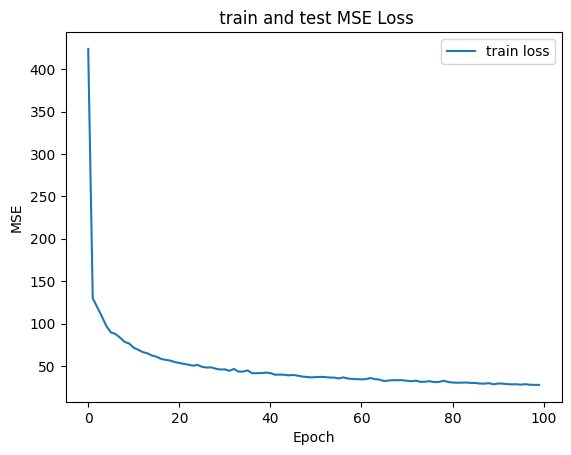

In [25]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
#plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
#plt.savefig('2-conv1d_OneHot-Loss-2pool.png')


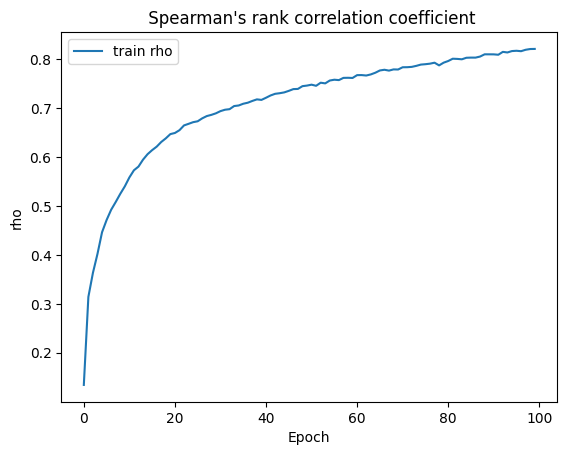

In [26]:
plt.plot(train_rho_history, label='train rho')
#plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
#plt.savefig('2-conv1d_OneHot-rho-2pool.png')

In [27]:
torch.save(model.state_dict(), f"5-AlexNet.pth")

In [29]:
test_df = pd.read_csv(path+ 'test.csv',index_col='seq_id')
test_df['tm']=submission_df['tm'].values
test_df = test_df.drop(columns=['protein_sequence','pH','data_source'])
test_df.to_csv('5-AlexNet.csv', index=True)